In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

# Data inladen
with open(Path('data/maandcijfers.json'), encoding='utf-8') as f:
    maand_data = json.load(f)['facts']
with open(Path('data/jaarcijfers.json'), encoding='utf-8') as f:
    jaar_data = json.load(f)['facts']

maand_df = pd.DataFrame(maand_data)
jaar_df = pd.DataFrame(jaar_data)


In [3]:
# Filter voor bouwsector (sectie F)
sectie_f_maand = maand_df[maand_df['Sectie'].str.startswith('F')]
# Filter NaN waarden uit de Sectie kolom voordat we filteren
sectie_f_jaar = jaar_df.dropna(subset=['Sectie'])[jaar_df.dropna(subset=['Sectie'])['Sectie'].str.startswith('F')]

# Gewesten
gewesten = sectie_f_maand['Gewest'].unique()

# Relevante kolommen
maand_kol = ['Gewest', 'Maand', 'Primo-registraties', 'Schrappingen', 'Btw-plichtig ond. aan het einde van de maand']
jaar_kol = ['Gewest', 'Jaar', 'Aantal oprichtingen', 'Aantal schrappingen', 'Aantal btw-plichtige']

sectie_f_maand = sectie_f_maand[maand_kol]
sectie_f_jaar = sectie_f_jaar[jaar_kol]

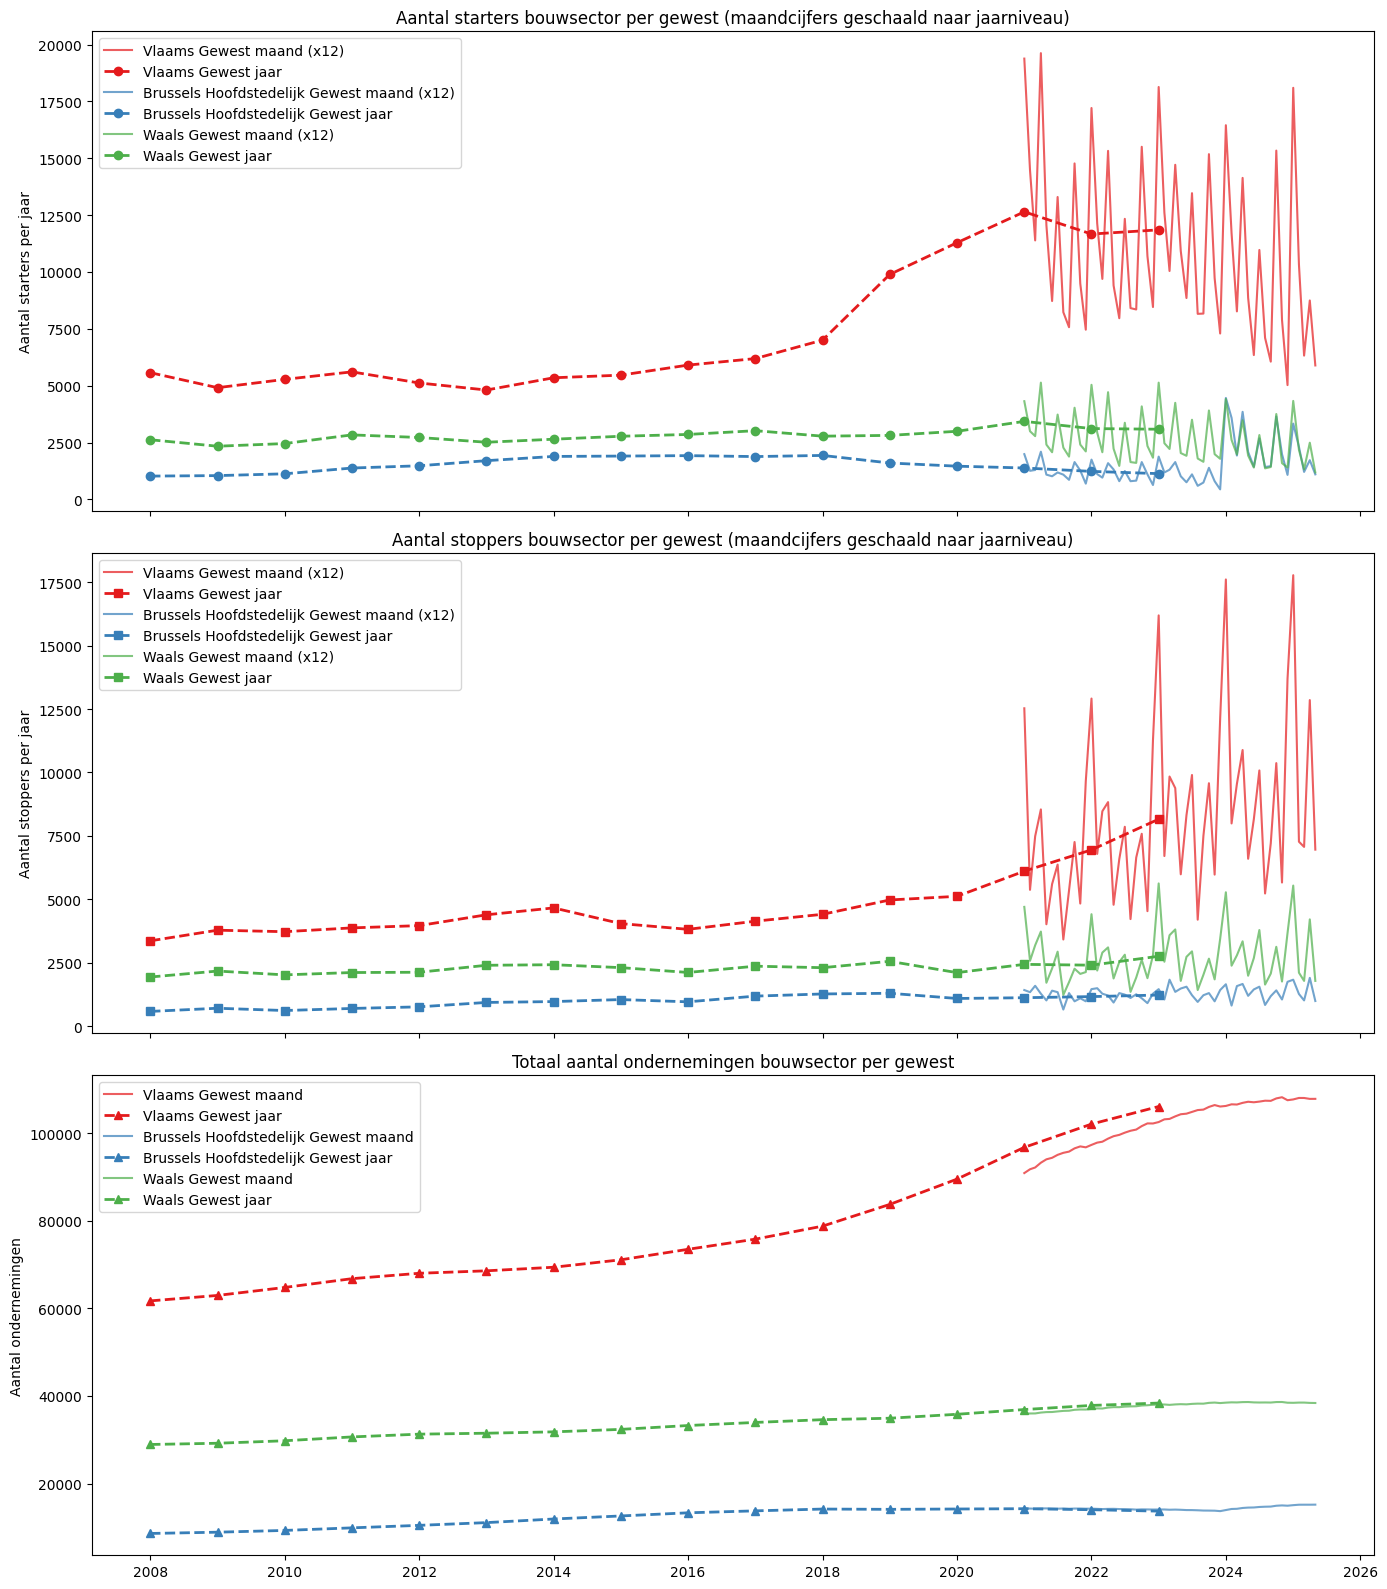

In [4]:
# Nederlandse maanden naar Engels mappen
maand_mapping = {
    'Januari': 'January', 'Februari': 'February', 'Maart': 'March',
    'April': 'April', 'Mei': 'May', 'Juni': 'June',
    'Juli': 'July', 'Augustus': 'August', 'September': 'September',
    'Oktober': 'October', 'November': 'November', 'December': 'December'
}

# Maak een functie om Nederlandse maandnamen om te zetten
def convert_dutch_month(date_str):
    for dutch, english in maand_mapping.items():
        if dutch in date_str:
            return date_str.replace(dutch, english)
    return date_str

# Maand en jaar naar tijd-as
sectie_f_maand['Maand_eng'] = sectie_f_maand['Maand'].apply(convert_dutch_month)
sectie_f_maand['Maand_dt'] = pd.to_datetime(sectie_f_maand['Maand_eng'], format='%B %Y')
sectie_f_jaar['Jaar_dt'] = pd.to_datetime(sectie_f_jaar['Jaar'], format='%Y')

# Filter gewesten - exclude Buitenland en Onbekend
gewesten_filtered = [g for g in gewesten if g not in ['Buitenland', 'Onbekend']]

# Kleurenpalette voor consistente kleuren per gewest
colors = plt.cm.Set1(range(len(gewesten_filtered)))
color_map = dict(zip(gewesten_filtered, colors))

fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)

# Starters - schaal maandcijfers naar jaarniveau (*12)
for gewest in gewesten_filtered:
    m = sectie_f_maand[sectie_f_maand['Gewest'] == gewest]
    y = sectie_f_jaar[sectie_f_jaar['Gewest'] == gewest]
    color = color_map[gewest]
    axes[0].plot(m['Maand_dt'], m['Primo-registraties'] * 12, color=color, alpha=0.7, label=f'{gewest} maand (x12)')
    axes[0].plot(y['Jaar_dt'], y['Aantal oprichtingen'], '--', color=color, linewidth=2, marker='o', markersize=6, label=f'{gewest} jaar')
axes[0].set_title('Aantal starters bouwsector per gewest (maandcijfers geschaald naar jaarniveau)')
axes[0].legend()
axes[0].set_ylabel('Aantal starters per jaar')

# Stoppers - schaal maandcijfers naar jaarniveau (*12)
for gewest in gewesten_filtered:
    m = sectie_f_maand[sectie_f_maand['Gewest'] == gewest]
    y = sectie_f_jaar[sectie_f_jaar['Gewest'] == gewest]
    color = color_map[gewest]
    axes[1].plot(m['Maand_dt'], -m['Schrappingen'] * 12, color=color, alpha=0.7, label=f'{gewest} maand (x12)')
    axes[1].plot(y['Jaar_dt'], y['Aantal schrappingen'], '--', color=color, linewidth=2, marker='s', markersize=6, label=f'{gewest} jaar')
axes[1].set_title('Aantal stoppers bouwsector per gewest (maandcijfers geschaald naar jaarniveau)')
axes[1].legend()
axes[1].set_ylabel('Aantal stoppers per jaar')

# Totaal ondernemingen - geen schaling nodig
for gewest in gewesten_filtered:
    m = sectie_f_maand[sectie_f_maand['Gewest'] == gewest]
    y = sectie_f_jaar[sectie_f_jaar['Gewest'] == gewest]
    color = color_map[gewest]
    axes[2].plot(m['Maand_dt'], m['Btw-plichtig ond. aan het einde van de maand'], color=color, alpha=0.7, label=f'{gewest} maand')
    axes[2].plot(y['Jaar_dt'], y['Aantal btw-plichtige'], '--', color=color, linewidth=2, marker='^', markersize=6, label=f'{gewest} jaar')
axes[2].set_title('Totaal aantal ondernemingen bouwsector per gewest')
axes[2].legend()
axes[2].set_ylabel('Aantal ondernemingen')

plt.tight_layout()
plt.show()

In [14]:
# Save the data used in the graphs to CSV files
import os
from pathlib import Path
import pandas as pd

# Create a data export directory if it doesn't exist
export_dir = Path('data/export')
export_dir.mkdir(exist_ok=True)

print("Saving graph data to CSV files...")
print("=" * 50)

# 1. Save monthly data (scaled to yearly level for starters and stoppers)
monthly_export = []
for gewest in gewesten_filtered:
    m = sectie_f_maand[sectie_f_maand['Gewest'] == gewest].copy()
    m['Starters_Scaled_Yearly'] = m['Primo-registraties'] * 12
    m['Stoppers_Scaled_Yearly'] = m['Schrappingen'] * 12
    m['Data_Type'] = 'Monthly'
    monthly_export.append(m[['Gewest', 'Maand', 'Maand_dt', 'Data_Type', 
                             'Primo-registraties', 'Starters_Scaled_Yearly',
                             'Schrappingen', 'Stoppers_Scaled_Yearly',
                             'Btw-plichtig ond. aan het einde van de maand']])

monthly_df = pd.concat(monthly_export, ignore_index=True)
monthly_file = export_dir / 'monthly_data_bouwsector.csv'
monthly_df.to_csv(monthly_file, index=False, encoding='utf-8-sig')
print(f"✅ Monthly data saved: {monthly_file}")

# 2. Save yearly data
yearly_export = []
for gewest in gewesten_filtered:
    y = sectie_f_jaar[sectie_f_jaar['Gewest'] == gewest].copy()
    y['Data_Type'] = 'Yearly'
    yearly_export.append(y[['Gewest', 'Jaar', 'Jaar_dt', 'Data_Type',
                            'Aantal oprichtingen', 'Aantal schrappingen', 'Aantal btw-plichtige']])

yearly_df = pd.concat(yearly_export, ignore_index=True)
yearly_file = export_dir / 'yearly_data_bouwsector.csv'
yearly_df.to_csv(yearly_file, index=False, encoding='utf-8-sig')
print(f"✅ Yearly data saved: {yearly_file}")

# 3. Save combined data for graph recreation
combined_data = []

# Add monthly data points (as used in graphs)
for gewest in gewesten_filtered:
    m = sectie_f_maand[sectie_f_maand['Gewest'] == gewest]
    for _, row in m.iterrows():
        combined_data.append({
            'Gewest': gewest,
            'Date': row['Maand_dt'],
            'Period': 'Monthly',
            'Period_Label': row['Maand'],
            'Starters': row['Primo-registraties'],
            'Starters_Yearly_Scaled': row['Primo-registraties'] * 12,
            'Stoppers': row['Schrappingen'],
            'Stoppers_Yearly_Scaled': row['Schrappingen'] * 12,
            'Total_Companies': row['Btw-plichtig ond. aan het einde van de maand']
        })

# Add yearly data points (as used in graphs)
for gewest in gewesten_filtered:
    y = sectie_f_jaar[sectie_f_jaar['Gewest'] == gewest]
    for _, row in y.iterrows():
        combined_data.append({
            'Gewest': gewest,
            'Date': row['Jaar_dt'],
            'Period': 'Yearly',
            'Period_Label': str(row['Jaar']),
            'Starters': row['Aantal oprichtingen'],
            'Starters_Yearly_Scaled': row['Aantal oprichtingen'],  # Already yearly
            'Stoppers': row['Aantal schrappingen'],
            'Stoppers_Yearly_Scaled': row['Aantal schrappingen'],  # Already yearly
            'Total_Companies': row['Aantal btw-plichtige']
        })

combined_df = pd.DataFrame(combined_data)
combined_df = combined_df.sort_values(['Gewest', 'Date'])
combined_file = export_dir / 'combined_graph_data_bouwsector.csv'
combined_df.to_csv(combined_file, index=False, encoding='utf-8-sig')
print(f"✅ Combined graph data saved: {combined_file}")

# 4. Create a summary file with metadata
summary_data = {
    'Dataset': ['Monthly Data', 'Yearly Data', 'Combined Graph Data'],
    'Filename': ['monthly_data_bouwsector.csv', 'yearly_data_bouwsector.csv', 'combined_graph_data_bouwsector.csv'],
    'Description': [
        'Monthly data with yearly scaling factors applied (starters and stoppers x12)',
        'Annual totals for starters, stoppers, and total companies',
        'All data points used in the three-panel graph, clearly labeled by period type'
    ],
    'Regions': [', '.join(gewesten_filtered)] * 3,
    'Time_Range_Monthly': [f"{monthly_df['Maand_dt'].min().strftime('%Y-%m')} to {monthly_df['Maand_dt'].max().strftime('%Y-%m')}"] * 3,
    'Time_Range_Yearly': [f"{yearly_df['Jaar_dt'].min().year} to {yearly_df['Jaar_dt'].max().year}"] * 3
}

summary_df = pd.DataFrame(summary_data)
summary_file = export_dir / 'data_export_summary.csv'
summary_df.to_csv(summary_file, index=False, encoding='utf-8-sig')
print(f"✅ Export summary saved: {summary_file}")

print("\n" + "=" * 50)
print("📊 Data Export Summary:")
print("=" * 50)
print(f"📁 Export directory: {export_dir}")
print(f"📈 Regions included: {', '.join(gewesten_filtered)}")
print(f"📅 Time range (monthly): {monthly_df['Maand_dt'].min().strftime('%Y-%m')} to {monthly_df['Maand_dt'].max().strftime('%Y-%m')}")
print(f"📅 Time range (yearly): {yearly_df['Jaar_dt'].min().year} to {yearly_df['Jaar_dt'].max().year}")
print(f"🔢 Total monthly records: {len(monthly_df)}")
print(f"🔢 Total yearly records: {len(yearly_df)}")
print(f"🔢 Total combined records: {len(combined_df)}")

print("\n📋 Files created:")
for file in [monthly_file, yearly_file, combined_file, summary_file]:
    size_kb = file.stat().st_size / 1024
    print(f"  • {file.name} ({size_kb:.1f} KB)")

Saving graph data to CSV files...
✅ Monthly data saved: data/export/monthly_data_bouwsector.csv
✅ Yearly data saved: data/export/yearly_data_bouwsector.csv
✅ Combined graph data saved: data/export/combined_graph_data_bouwsector.csv
✅ Export summary saved: data/export/data_export_summary.csv

📊 Data Export Summary:
📁 Export directory: data/export
📈 Regions included: Vlaams Gewest, Brussels Hoofdstedelijk Gewest, Waals Gewest
📅 Time range (monthly): 2021-01 to 2025-05
📅 Time range (yearly): 2008 to 2023
🔢 Total monthly records: 159
🔢 Total yearly records: 48
🔢 Total combined records: 207

📋 Files created:
  • monthly_data_bouwsector.csv (13.6 KB)
  • yearly_data_bouwsector.csv (3.1 KB)
  • combined_graph_data_bouwsector.csv (17.3 KB)
  • data_export_summary.csv (0.7 KB)


In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Kleurenpalette voor consistente kleuren per gewest (Plotly kleuren)
color_map_plotly = {
    'Vlaams Gewest': '#1f77b4',      # blauw
    'Brussels Hoofdstedelijk Gewest': '#ff7f0e',  # oranje
    'Waals Gewest': '#2ca02c'        # groen
}

# Maak subplots
fig_plotly = make_subplots(
    rows=3, cols=1,
    subplot_titles=(
        'Aantal starters bouwsector per gewest (maandcijfers geschaald naar jaarniveau)',
        'Aantal stoppers bouwsector per gewest (maandcijfers geschaald naar jaarniveau)', 
        'Totaal aantal ondernemingen bouwsector per gewest'
    ),
    vertical_spacing=0.08,
    shared_xaxes=True
)

# Starters - schaal maandcijfers naar jaarniveau (*12)
for gewest in gewesten_filtered:
    m = sectie_f_maand[sectie_f_maand['Gewest'] == gewest]
    y = sectie_f_jaar[sectie_f_jaar['Gewest'] == gewest]
    color = color_map_plotly[gewest]
    
    # Maandcijfers
    fig_plotly.add_trace(
        go.Scatter(
            x=m['Maand_dt'], 
            y=m['Primo-registraties'] * 12,
            mode='lines',
            name=f'{gewest} maand (x12)',
            line=dict(color=color, width=2),
            opacity=0.7,
            legendgroup=gewest,
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Jaarcijfers
    fig_plotly.add_trace(
        go.Scatter(
            x=y['Jaar_dt'], 
            y=y['Aantal oprichtingen'],
            mode='lines+markers',
            name=f'{gewest} jaar',
            line=dict(color=color, width=3, dash='dash'),
            marker=dict(size=8, symbol='circle'),
            legendgroup=gewest,
            showlegend=False
        ),
        row=1, col=1
    )

# Stoppers - schaal maandcijfers naar jaarniveau (*12)
for gewest in gewesten_filtered:
    m = sectie_f_maand[sectie_f_maand['Gewest'] == gewest]
    y = sectie_f_jaar[sectie_f_jaar['Gewest'] == gewest]
    color = color_map_plotly[gewest]
    
    # Maandcijfers
    fig_plotly.add_trace(
        go.Scatter(
            x=m['Maand_dt'], 
            y=-m['Schrappingen'] * 12,
            mode='lines',
            name=f'{gewest} maand (x12)',
            line=dict(color=color, width=2),
            opacity=0.7,
            legendgroup=gewest,
            showlegend=False
        ),
        row=2, col=1
    )
    
    # Jaarcijfers
    fig_plotly.add_trace(
        go.Scatter(
            x=y['Jaar_dt'], 
            y=y['Aantal schrappingen'],
            mode='lines+markers',
            name=f'{gewest} jaar',
            line=dict(color=color, width=3, dash='dash'),
            marker=dict(size=8, symbol='square'),
            legendgroup=gewest,
            showlegend=False
        ),
        row=2, col=1
    )

# Totaal ondernemingen - geen schaling nodig
for gewest in gewesten_filtered:
    m = sectie_f_maand[sectie_f_maand['Gewest'] == gewest]
    y = sectie_f_jaar[sectie_f_jaar['Gewest'] == gewest]
    color = color_map_plotly[gewest]
    
    # Maandcijfers
    fig_plotly.add_trace(
        go.Scatter(
            x=m['Maand_dt'], 
            y=m['Btw-plichtig ond. aan het einde van de maand'],
            mode='lines',
            name=f'{gewest} maand',
            line=dict(color=color, width=2),
            opacity=0.7,
            legendgroup=gewest,
            showlegend=False
        ),
        row=3, col=1
    )
    
    # Jaarcijfers
    fig_plotly.add_trace(
        go.Scatter(
            x=y['Jaar_dt'], 
            y=y['Aantal btw-plichtige'],
            mode='lines+markers',
            name=f'{gewest} jaar',
            line=dict(color=color, width=3, dash='dash'),
            marker=dict(size=8, symbol='triangle-up'),
            legendgroup=gewest,
            showlegend=False
        ),
        row=3, col=1
    )

# Layout aanpassingen
fig_plotly.update_layout(
    height=1000,
    title_text="Bouwsector (Sectie F) - Starters, Stoppers en Totaal Ondernemingen per Gewest",
    title_x=0.5,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    annotations=[
        dict(
            x=0.5,
            y=-20,
            xref='paper',
            yref='paper',
            text='Bron: Statbel, verwerking Embuild Vlaanderen | <a href="https://statbel.fgov.be/nl/themas/ondernemingen/btw-plichtige-ondernemingen">https://statbel.fgov.be/nl/themas/ondernemingen/btw-plichtige-ondernemingen</a>',
            showarrow=False,
            font=dict(size=10, color="gray"),
            xanchor='center'
        )
    ]
)

# Y-as labels
fig_plotly.update_yaxes(title_text="Aantal starters per jaar", row=1, col=1)
fig_plotly.update_yaxes(title_text="Aantal stoppers per jaar", row=2, col=1)
fig_plotly.update_yaxes(title_text="Aantal ondernemingen", row=3, col=1)

# X-as label alleen voor de onderste grafiek
fig_plotly.update_xaxes(title_text="Jaar", row=3, col=1)

fig_plotly.show()

In [7]:
# Jaar-op-jaar (YoY) veranderingen berekenen voor maanddata
import numpy as np

# Functie om YoY veranderingen te berekenen
def calculate_yoy_changes(df, value_col, date_col, gewest_col):
    """
    Berekent jaar-op-jaar veranderingen voor maandelijkse data
    """
    df_copy = df.copy()
    df_copy['Year'] = df_copy[date_col].dt.year
    df_copy['Month'] = df_copy[date_col].dt.month
    
    # Sorteer op gewest, jaar en maand
    df_copy = df_copy.sort_values([gewest_col, 'Year', 'Month'])
    
    # Bereken YoY verandering (huidige waarde - waarde van vorig jaar)
    df_copy['YoY_Change'] = df_copy.groupby([gewest_col, 'Month'])[value_col].diff(periods=1)
    df_copy['YoY_Change_Pct'] = df_copy.groupby([gewest_col, 'Month'])[value_col].pct_change(periods=1) * 100
    
    return df_copy

# Filter voor gewesten (exclusief Buitenland en Onbekend)
sectie_f_maand_filtered = sectie_f_maand[sectie_f_maand['Gewest'].isin(gewesten_filtered)].copy()

# Bereken YoY voor starters
starters_yoy = calculate_yoy_changes(
    sectie_f_maand_filtered, 
    'Primo-registraties', 
    'Maand_dt', 
    'Gewest'
)

# Bereken YoY voor stoppers
stoppers_yoy = calculate_yoy_changes(
    sectie_f_maand_filtered, 
    'Schrappingen', 
    'Maand_dt', 
    'Gewest'
)

# Bereken YoY voor totaal ondernemingen
totaal_yoy = calculate_yoy_changes(
    sectie_f_maand_filtered, 
    'Btw-plichtig ond. aan het einde van de maand', 
    'Maand_dt', 
    'Gewest'
)

print("YoY berekeningen voltooid!")

YoY berekeningen voltooid!


In [8]:
# Tabel 1: YoY veranderingen Starters per gewest
print("=" * 80)
print("TABEL 1: JAAR-OP-JAAR VERANDERINGEN STARTERS (PRIMO-REGISTRATIES)")
print("=" * 80)

# Filter alleen data vanaf 2021 (om YoY berekeningen te hebben)
starters_yoy_table = starters_yoy[starters_yoy['Year'] >= 2021].copy()

# Maak een pivot tabel voor absolute veranderingen
starters_abs_pivot = starters_yoy_table.pivot_table(
    index=['Year', 'Month'], 
    columns='Gewest', 
    values='YoY_Change', 
    fill_value=np.nan
)

# Maak een pivot tabel voor percentage veranderingen
starters_pct_pivot = starters_yoy_table.pivot_table(
    index=['Year', 'Month'], 
    columns='Gewest', 
    values='YoY_Change_Pct', 
    fill_value=np.nan
)

print("\nAbsolute veranderingen (aantal starters t.o.v. zelfde maand vorig jaar):")
print("-" * 70)
print(starters_abs_pivot.round(0).astype('Int64'))

print("\n\nPercentage veranderingen (% t.o.v. zelfde maand vorig jaar):")
print("-" * 70)
print(starters_pct_pivot.round(1).astype(str) + "%")

# Gemiddelde YoY veranderingen per gewest
print("\n\nGemiddelde YoY veranderingen per gewest (2021-2024):")
print("-" * 50)
starters_avg = starters_yoy_table.groupby('Gewest').agg({
    'YoY_Change': ['mean', 'std'],
    'YoY_Change_Pct': ['mean', 'std']
}).round(2)

for gewest in gewesten_filtered:
    abs_mean = starters_avg.loc[gewest, ('YoY_Change', 'mean')]
    abs_std = starters_avg.loc[gewest, ('YoY_Change', 'std')]
    pct_mean = starters_avg.loc[gewest, ('YoY_Change_Pct', 'mean')]
    pct_std = starters_avg.loc[gewest, ('YoY_Change_Pct', 'std')]
    
    print(f"{gewest}:")
    print(f"  Gemiddeld: {abs_mean:+.0f} starters ({pct_mean:+.1f}%)")
    print(f"  Standaarddeviatie: ±{abs_std:.0f} starters (±{pct_std:.1f}%)")
    print()

TABEL 1: JAAR-OP-JAAR VERANDERINGEN STARTERS (PRIMO-REGISTRATIES)

Absolute veranderingen (aantal starters t.o.v. zelfde maand vorig jaar):
----------------------------------------------------------------------
Gewest      Brussels Hoofdstedelijk Gewest  Vlaams Gewest  Waals Gewest
Year Month                                                             
2022 1                                 -20           -181            60
     2                                 -12           -195            -5
     3                                 -28           -141           -59
     4                                 -42           -358           -35
     5                                  19           -221           -15
     6                                 -18            -63           -50
     7                                   5            -80           -30
     8                                 -24             15           -53
     9                                  -3             65           -

In [9]:
# Tabel 2: YoY veranderingen Stoppers per gewest
print("=" * 80)
print("TABEL 2: JAAR-OP-JAAR VERANDERINGEN STOPPERS (SCHRAPPINGEN)")
print("=" * 80)

# Filter alleen data vanaf 2021 (om YoY berekeningen te hebben)
stoppers_yoy_table = stoppers_yoy[stoppers_yoy['Year'] >= 2021].copy()

# Maak een pivot tabel voor absolute veranderingen
stoppers_abs_pivot = stoppers_yoy_table.pivot_table(
    index=['Year', 'Month'], 
    columns='Gewest', 
    values='YoY_Change', 
    fill_value=np.nan
)

# Maak een pivot tabel voor percentage veranderingen
stoppers_pct_pivot = stoppers_yoy_table.pivot_table(
    index=['Year', 'Month'], 
    columns='Gewest', 
    values='YoY_Change_Pct', 
    fill_value=np.nan
)

print("\nAbsolute veranderingen (aantal stoppers t.o.v. zelfde maand vorig jaar):")
print("-" * 70)
print(stoppers_abs_pivot.round(0).astype('Int64'))

print("\n\nPercentage veranderingen (% t.o.v. zelfde maand vorig jaar):")
print("-" * 70)
print(stoppers_pct_pivot.round(1).astype(str) + "%")

# Gemiddelde YoY veranderingen per gewest
print("\n\nGemiddelde YoY veranderingen per gewest (2021-2024):")
print("-" * 50)
stoppers_avg = stoppers_yoy_table.groupby('Gewest').agg({
    'YoY_Change': ['mean', 'std'],
    'YoY_Change_Pct': ['mean', 'std']
}).round(2)

for gewest in gewesten_filtered:
    abs_mean = stoppers_avg.loc[gewest, ('YoY_Change', 'mean')]
    abs_std = stoppers_avg.loc[gewest, ('YoY_Change', 'std')]
    pct_mean = stoppers_avg.loc[gewest, ('YoY_Change_Pct', 'mean')]
    pct_std = stoppers_avg.loc[gewest, ('YoY_Change_Pct', 'std')]
    
    print(f"{gewest}:")
    print(f"  Gemiddeld: {abs_mean:+.0f} stoppers ({pct_mean:+.1f}%)")
    print(f"  Standaarddeviatie: ±{abs_std:.0f} stoppers (±{pct_std:.1f}%)")
    print()

TABEL 2: JAAR-OP-JAAR VERANDERINGEN STOPPERS (SCHRAPPINGEN)

Absolute veranderingen (aantal stoppers t.o.v. zelfde maand vorig jaar):
----------------------------------------------------------------------
Gewest      Brussels Hoofdstedelijk Gewest  Vlaams Gewest  Waals Gewest
Year Month                                                             
2022 1                                  -3            -32            24
     2                                 -13           -118            32
     3                                  26            -82            24
     4                                   6            -24            52
     5                                   7            -64           -14
     6                                   8            -82           -21
     7                                   8           -124            10
     8                                 -38            -67           -10
     9                                   4           -108           -15
   

In [10]:
# Tabel 3: YoY veranderingen Totaal Ondernemingen per gewest
print("=" * 80)
print("TABEL 3: JAAR-OP-JAAR VERANDERINGEN TOTAAL ONDERNEMINGEN")
print("=" * 80)

# Filter alleen data vanaf 2021 (om YoY berekeningen te hebben)
totaal_yoy_table = totaal_yoy[totaal_yoy['Year'] >= 2021].copy()

# Maak een pivot tabel voor absolute veranderingen
totaal_abs_pivot = totaal_yoy_table.pivot_table(
    index=['Year', 'Month'], 
    columns='Gewest', 
    values='YoY_Change', 
    fill_value=np.nan
)

# Maak een pivot tabel voor percentage veranderingen
totaal_pct_pivot = totaal_yoy_table.pivot_table(
    index=['Year', 'Month'], 
    columns='Gewest', 
    values='YoY_Change_Pct', 
    fill_value=np.nan
)

print("\nAbsolute veranderingen (aantal ondernemingen t.o.v. zelfde maand vorig jaar):")
print("-" * 70)
print(totaal_abs_pivot.round(0).astype('Int64'))

print("\n\nPercentage veranderingen (% t.o.v. zelfde maand vorig jaar):")
print("-" * 70)
print(totaal_pct_pivot.round(1).astype(str) + "%")

# Gemiddelde YoY veranderingen per gewest
print("\n\nGemiddelde YoY veranderingen per gewest (2021-2024):")
print("-" * 50)
totaal_avg = totaal_yoy_table.groupby('Gewest').agg({
    'YoY_Change': ['mean', 'std'],
    'YoY_Change_Pct': ['mean', 'std']
}).round(2)

for gewest in gewesten_filtered:
    abs_mean = totaal_avg.loc[gewest, ('YoY_Change', 'mean')]
    abs_std = totaal_avg.loc[gewest, ('YoY_Change', 'std')]
    pct_mean = totaal_avg.loc[gewest, ('YoY_Change_Pct', 'mean')]
    pct_std = totaal_avg.loc[gewest, ('YoY_Change_Pct', 'std')]
    
    print(f"{gewest}:")
    print(f"  Gemiddeld: {abs_mean:+.0f} ondernemingen ({pct_mean:+.1f}%)")
    print(f"  Standaarddeviatie: ±{abs_std:.0f} ondernemingen (±{pct_std:.1f}%)")
    print()

TABEL 3: JAAR-OP-JAAR VERANDERINGEN TOTAAL ONDERNEMINGEN

Absolute veranderingen (aantal ondernemingen t.o.v. zelfde maand vorig jaar):
----------------------------------------------------------------------
Gewest      Brussels Hoofdstedelijk Gewest  Vlaams Gewest  Waals Gewest
Year Month                                                             
2022 1                                 -35           6431          1144
     2                                 -72           6082          1161
     3                                 -87           5882          1118
     4                                -108           5500          1138
     5                                -101           5281          1133
     6                                -117           5234          1101
     7                                 -96           5065          1094
     8                                -175           5037          1027
     9                                -196           5033          1014
 

In [11]:
# Samenvatting van YoY trends per gewest
print("=" * 80)
print("SAMENVATTING: BELANGRIJKSTE YoY TRENDS PER GEWEST (2021-2024)")
print("=" * 80)

# Bereken de meest recente 12 maanden voor elke categorie
recent_period = pd.Timestamp('2024-01-01')

print("\n📈 STARTERS (Primo-registraties):")
print("-" * 40)
for gewest in gewesten_filtered:
    data = starters_yoy_table[starters_yoy_table['Gewest'] == gewest]
    recent_data = data[data['Maand_dt'] >= recent_period]
    
    if not recent_data.empty:
        avg_recent = recent_data['YoY_Change_Pct'].mean()
        latest_month = recent_data.loc[recent_data['Maand_dt'].idxmax()]
        
        trend = "📈 stijgend" if avg_recent > 0 else "📉 dalend" if avg_recent < 0 else "➡️ stabiel"
        
        print(f"{gewest}: {trend}")
        print(f"  • Gemiddelde YoY (2024): {avg_recent:+.1f}%")
        print(f"  • Laatste maand: {latest_month['Maand']} ({latest_month['YoY_Change_Pct']:+.1f}%)")
        print()

print("\n🔻 STOPPERS (Schrappingen):")
print("-" * 40)
for gewest in gewesten_filtered:
    data = stoppers_yoy_table[stoppers_yoy_table['Gewest'] == gewest]
    recent_data = data[data['Maand_dt'] >= recent_period]
    
    if not recent_data.empty:
        avg_recent = recent_data['YoY_Change_Pct'].mean()
        latest_month = recent_data.loc[recent_data['Maand_dt'].idxmax()]
        
        trend = "📈 meer stoppers" if avg_recent > 0 else "📉 minder stoppers" if avg_recent < 0 else "➡️ stabiel"
        
        print(f"{gewest}: {trend}")
        print(f"  • Gemiddelde YoY (2024): {avg_recent:+.1f}%")
        print(f"  • Laatste maand: {latest_month['Maand']} ({latest_month['YoY_Change_Pct']:+.1f}%)")
        print()

print("\n🏢 TOTAAL ONDERNEMINGEN:")
print("-" * 40)
for gewest in gewesten_filtered:
    data = totaal_yoy_table[totaal_yoy_table['Gewest'] == gewest]
    recent_data = data[data['Maand_dt'] >= recent_period]
    
    if not recent_data.empty:
        avg_recent = recent_data['YoY_Change_Pct'].mean()
        latest_month = recent_data.loc[recent_data['Maand_dt'].idxmax()]
        
        trend = "📈 groeiend" if avg_recent > 0 else "📉 krimpend" if avg_recent < 0 else "➡️ stabiel"
        
        print(f"{gewest}: {trend}")
        print(f"  • Gemiddelde YoY (2024): {avg_recent:+.1f}%")
        print(f"  • Laatste maand: {latest_month['Maand']} ({latest_month['YoY_Change_Pct']:+.1f}%)")
        print()

print("\n" + "=" * 80)

SAMENVATTING: BELANGRIJKSTE YoY TRENDS PER GEWEST (2021-2024)

📈 STARTERS (Primo-registraties):
----------------------------------------
Vlaams Gewest: 📉 dalend
  • Gemiddelde YoY (2024): -17.0%
  • Laatste maand: Mei 2025 (-33.6%)

Brussels Hoofdstedelijk Gewest: 📈 stijgend
  • Gemiddelde YoY (2024): +79.2%
  • Laatste maand: Mei 2025 (-47.1%)

Waals Gewest: 📉 dalend
  • Gemiddelde YoY (2024): -17.1%
  • Laatste maand: Mei 2025 (-38.5%)


🔻 STOPPERS (Schrappingen):
----------------------------------------
Vlaams Gewest: 📈 meer stoppers
  • Gemiddelde YoY (2024): +4.5%
  • Laatste maand: Mei 2025 (+5.5%)

Brussels Hoofdstedelijk Gewest: 📈 meer stoppers
  • Gemiddelde YoY (2024): +3.1%
  • Laatste maand: Mei 2025 (-17.0%)

Waals Gewest: 📈 meer stoppers
  • Gemiddelde YoY (2024): +0.1%
  • Laatste maand: Mei 2025 (-10.2%)


🏢 TOTAAL ONDERNEMINGEN:
----------------------------------------
Vlaams Gewest: 📈 groeiend
  • Gemiddelde YoY (2024): +2.1%
  • Laatste maand: Mei 2025 (+0.6%)

Bruss

In [15]:
# Sla YoY tabellen op als HTML-bestand
from datetime import datetime

def create_html_table(pivot_df, title, subtitle, percentage=False):
    """
    Creëer een HTML tabel van een pivot DataFrame
    """
    html = f"""
    <div class="table-container">
        <h2>{title}</h2>
        <h3>{subtitle}</h3>
        <table class="yoy-table">
            <thead>
                <tr>
                    <th rowspan="2">Jaar</th>
                    <th rowspan="2">Maand</th>"""
    
    # Kolomheaders (gewesten)
    for gewest in pivot_df.columns:
        html += f'<th>{gewest}</th>'
    
    html += """
                </tr>
            </thead>
            <tbody>"""
    
    # Data rijen
    for (year, month), row in pivot_df.iterrows():
        month_name = {1: 'Jan', 2: 'Feb', 3: 'Mrt', 4: 'Apr', 5: 'Mei', 6: 'Jun',
                      7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Okt', 11: 'Nov', 12: 'Dec'}[month]
        
        html += f"""
                <tr>
                    <td>{year}</td>
                    <td>{month_name}</td>"""
        
        for gewest in pivot_df.columns:
            value = row[gewest]
            if pd.isna(value):
                html += '<td class="na-value">-</td>'
            else:
                if percentage:
                    color_class = 'positive' if value > 0 else 'negative' if value < 0 else 'neutral'
                    html += f'<td class="{color_class}">{value:.1f}%</td>'
                else:
                    color_class = 'positive' if value > 0 else 'negative' if value < 0 else 'neutral'
                    html += f'<td class="{color_class}">{value:.0f}</td>'
        
        html += '</tr>'
    
    html += """
            </tbody>
        </table>
    </div>
    """
    
    return html

# CSS stijlen
css_styles = """
<style>
    body {
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        line-height: 1.6;
        margin: 20px;
        background-color: #f8f9fa;
    }
    
    .header {
        text-align: center;
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 30px;
        border-radius: 10px;
        margin-bottom: 30px;
        box-shadow: 0 4px 6px rgba(0,0,0,0.1);
    }
    
    .header h1 {
        margin: 0 0 10px 0;
        font-size: 2.5em;
        font-weight: 300;
    }
    
    .header p {
        margin: 0;
        font-size: 1.1em;
        opacity: 0.9;
    }
    
    .table-container {
        background: white;
        margin: 30px 0;
        border-radius: 10px;
        overflow: hidden;
        box-shadow: 0 2px 10px rgba(0,0,0,0.1);
    }
    
    .table-container h2 {
        background: #343a40;
        color: white;
        margin: 0;
        padding: 20px;
        font-size: 1.5em;
        font-weight: 500;
    }
    
    .table-container h3 {
        background: #6c757d;
        color: white;
        margin: 0;
        padding: 15px 20px;
        font-size: 1.1em;
        font-weight: 400;
    }
    
    .yoy-table {
        width: 100%;
        border-collapse: collapse;
        font-size: 0.9em;
    }
    
    .yoy-table th {
        background: #495057;
        color: white;
        padding: 12px 8px;
        text-align: center;
        font-weight: 600;
        border: 1px solid #dee2e6;
    }
    
    .yoy-table td {
        padding: 10px 8px;
        text-align: center;
        border: 1px solid #dee2e6;
        font-weight: 500;
    }
    
    .yoy-table tbody tr:nth-child(even) {
        background-color: #f8f9fa;
    }
    
    .yoy-table tbody tr:hover {
        background-color: #e9ecef;
    }
    
    .positive {
        color: #28a745;
        font-weight: 600;
    }
    
    .negative {
        color: #dc3545;
        font-weight: 600;
    }
    
    .neutral {
        color: #6c757d;
    }
    
    .na-value {
        color: #adb5bd;
        font-style: italic;
    }
    
    .summary-box {
        background: #e9ecef;
        border-left: 5px solid #007bff;
        padding: 20px;
        margin: 30px 0;
        border-radius: 5px;
    }
    
    .summary-box h3 {
        color: #495057;
        margin: 0 0 15px 0;
    }
    
    .summary-item {
        margin: 10px 0;
        padding: 10px;
        background: white;
        border-radius: 5px;
        border-left: 3px solid #007bff;
    }
    
    .footer {
        text-align: center;
        margin-top: 50px;
        padding: 20px;
        background: #343a40;
        color: white;
        border-radius: 10px;
    }
    
    .footer a {
        color: #17a2b8;
        text-decoration: none;
    }
    
    .footer a:hover {
        text-decoration: underline;
    }
</style>
"""

# Begin HTML document
html_content = f"""
<!DOCTYPE html>
<html lang="nl">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>YoY Analyse Bouwsector - Statbel Data</title>
    {css_styles}
</head>
<body>
    <div class="header">
        <h1>Jaar-op-Jaar Analyse Bouwsector (Sectie F)</h1>
        <p>Veranderingen per gewest • Gegenereerd op {datetime.now().strftime('%d %B %Y om %H:%M')}</p>
    </div>
"""

# Voeg tabellen toe
html_content += create_html_table(
    starters_abs_pivot, 
    "Tabel 1: Starters (Primo-registraties)",
    "Absolute veranderingen t.o.v. zelfde maand vorig jaar"
)

html_content += create_html_table(
    starters_pct_pivot, 
    "Tabel 1: Starters (Primo-registraties)",
    "Percentage veranderingen t.o.v. zelfde maand vorig jaar",
    percentage=True
)

html_content += create_html_table(
    stoppers_abs_pivot, 
    "Tabel 2: Stoppers (Schrappingen)",
    "Absolute veranderingen t.o.v. zelfde maand vorig jaar"
)

html_content += create_html_table(
    stoppers_pct_pivot, 
    "Tabel 2: Stoppers (Schrappingen)",
    "Percentage veranderingen t.o.v. zelfde maand vorig jaar",
    percentage=True
)

html_content += create_html_table(
    totaal_abs_pivot, 
    "Tabel 3: Totaal Ondernemingen",
    "Absolute veranderingen t.o.v. zelfde maand vorig jaar"
)

html_content += create_html_table(
    totaal_pct_pivot, 
    "Tabel 3: Totaal Ondernemingen",
    "Percentage veranderingen t.o.v. zelfde maand vorig jaar",
    percentage=True
)

# Voeg samenvatting toe
html_content += """
    <div class="summary-box">
        <h3>📊 Samenvatting Trends (2024)</h3>
"""

for gewest in gewesten_filtered:
    starters_trend = starters_yoy_table[
        (starters_yoy_table['Gewest'] == gewest) & 
        (starters_yoy_table['Maand_dt'] >= recent_period)
    ]['YoY_Change_Pct'].mean()
    
    stoppers_trend = stoppers_yoy_table[
        (stoppers_yoy_table['Gewest'] == gewest) & 
        (stoppers_yoy_table['Maand_dt'] >= recent_period)
    ]['YoY_Change_Pct'].mean()
    
    totaal_trend = totaal_yoy_table[
        (totaal_yoy_table['Gewest'] == gewest) & 
        (totaal_yoy_table['Maand_dt'] >= recent_period)
    ]['YoY_Change_Pct'].mean()
    
    html_content += f"""
        <div class="summary-item">
            <strong>{gewest}:</strong><br>
            Starters: <span class="{'positive' if starters_trend > 0 else 'negative'}">{starters_trend:+.1f}%</span> • 
            Stoppers: <span class="{'negative' if stoppers_trend > 0 else 'positive'}">{stoppers_trend:+.1f}%</span> • 
            Totaal: <span class="{'positive' if totaal_trend > 0 else 'negative'}">{totaal_trend:+.1f}%</span>
        </div>
    """

html_content += """
    </div>
    
    <div class="footer">
        <p><strong>Bron:</strong> Statbel, verwerking Embuild Vlaanderen</p>
        <p><a href="https://statbel.fgov.be/nl/themas/ondernemingen/btw-plichtige-ondernemingen">
           https://statbel.fgov.be/nl/themas/ondernemingen/btw-plichtige-ondernemingen</a></p>
    </div>
</body>
</html>
"""

# Schrijf naar bestand
filename = 'yoy_analyse_bouwsector.html'
with open(filename, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"✅ HTML-bestand succesvol opgeslagen: {filename}")
print(f"📂 Locatie: {Path.cwd() / filename}")
print(f"🌐 Open het bestand in een webbrowser om de geformatteerde tabellen te bekijken")

✅ HTML-bestand succesvol opgeslagen: yoy_analyse_bouwsector.html
📂 Locatie: /Users/gerthuybrechts/pyprojects/statbel_starters/yoy_analyse_bouwsector.html
🌐 Open het bestand in een webbrowser om de geformatteerde tabellen te bekijken


In [13]:
# Tabel: Totaal aantal starters per jaar gebaseerd op maanddata
print("=" * 80)
print("TABEL: TOTAAL AANTAL STARTERS PER JAAR (GEBASEERD OP MAANDDATA)")
print("=" * 80)

# Bereken jaartotalen per gewest uit maanddata
sectie_f_maand_filtered['Year'] = sectie_f_maand_filtered['Maand_dt'].dt.year

yearly_starters = sectie_f_maand_filtered.groupby(['Year', 'Gewest'])['Primo-registraties'].sum().reset_index()

# Maak een pivot tabel voor betere leesbaarheid
yearly_starters_pivot = yearly_starters.pivot(index='Year', columns='Gewest', values='Primo-registraties')

# Voeg een totaal kolom toe
yearly_starters_pivot['TOTAAL'] = yearly_starters_pivot.sum(axis=1)

print("\nAantal starters per jaar per gewest (som van alle maanden):")
print("-" * 70)

# Toon de tabel met formatting
print(f"{'Jaar':<6}", end="")
for gewest in gewesten_filtered:
    print(f"{gewest:<35}", end="")
print(f"{'TOTAAL':<12}")
print("-" * 120)

for year in sorted(yearly_starters_pivot.index):
    print(f"{year:<6}", end="")
    for gewest in gewesten_filtered:
        value = yearly_starters_pivot.loc[year, gewest]
        if pd.notna(value):
            print(f"{int(value):>8,}{'':<27}", end="")
        else:
            print(f"{'N/A':<35}", end="")
    
    total = yearly_starters_pivot.loc[year, 'TOTAAL']
    print(f"{int(total):>8,}")

print("-" * 120)

# Toon gemiddelden
print("\nGemiddelde aantal starters per jaar (over beschikbare jaren):")
print("-" * 60)
for gewest in gewesten_filtered:
    avg_value = yearly_starters_pivot[gewest].mean()
    print(f"{gewest:<35}: {avg_value:>8,.0f}")

total_avg = yearly_starters_pivot['TOTAAL'].mean()
print(f"{'TOTAAL':<35}: {total_avg:>8,.0f}")

# Toon jaar-op-jaar groei
print("\n\nJaar-op-jaar groei (%):")
print("-" * 60)
print(f"{'Jaar':<6}", end="")
for gewest in gewesten_filtered:
    print(f"{gewest:<20}", end="")
print(f"{'TOTAAL':<12}")
print("-" * 90)

for i, year in enumerate(sorted(yearly_starters_pivot.index)[1:], 1):
    prev_year = sorted(yearly_starters_pivot.index)[i-1]
    print(f"{year:<6}", end="")
    
    for gewest in gewesten_filtered:
        current = yearly_starters_pivot.loc[year, gewest]
        previous = yearly_starters_pivot.loc[prev_year, gewest]
        
        if pd.notna(current) and pd.notna(previous) and previous != 0:
            growth = ((current - previous) / previous) * 100
            print(f"{growth:>+6.1f}%{'':<13}", end="")
        else:
            print(f"{'N/A':<20}", end="")
    
    # Totaal groei
    current_total = yearly_starters_pivot.loc[year, 'TOTAAL']
    previous_total = yearly_starters_pivot.loc[prev_year, 'TOTAAL']
    total_growth = ((current_total - previous_total) / previous_total) * 100
    print(f"{total_growth:>+6.1f}%")

print("-" * 90)

TABEL: TOTAAL AANTAL STARTERS PER JAAR (GEBASEERD OP MAANDDATA)

Aantal starters per jaar per gewest (som van alle maanden):
----------------------------------------------------------------------
Jaar  Vlaams Gewest                      Brussels Hoofdstedelijk Gewest     Waals Gewest                       TOTAAL      
------------------------------------------------------------------------------------------------------------------------
2021    12,206                              1,293                              3,015                             16,514
2022    11,291                              1,151                              2,782                             15,224
2023    11,440                              1,074                              2,724                             15,238
2024     9,847                              2,472                              2,351                             14,670
2025     4,116                                808                              